# Word2Vec


Word2vec is a widely-used algorithm for learning embeddings of words. It is an interesting algorithm and is surprising in its effectiveness.

Adapted from https://github.com/tensorflow/tensorflow/blob/r0.7/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [1]:
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import deque, Counter
import os
import zipfile
import numpy as np
import urllib2
import random
import tensorflow as tf
import math
from sklearn.cross_validation import train_test_split

First download the data we will use, e.g.

```
curl -O http://mattmahoney.net/dc/text8.zip
```

This dataset is a small exerpt of wikipedia with all punctuation removed.

In [2]:
# Read the data into a string.
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return f.read(name).split()
    f.close()

words = read_data('text8.zip')
print 'Data size', len(words)

Data size 17005207


We prepare the dataset by replacing rare words with a single "UNK" word (for "unknown"). This allows us to control the vocabulary size that we want to learn embeddings for. We assign each word in the vocabulary an index and we create a mapping between words and their indexes.

In [3]:

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

vocabulary_size = 50000

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print 'Most common words (+UNK)', count[:5]
print 'Sample data', data[:10]

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Next we define a function to generate batch from the data based on the parameters we set.

For example, suppose we have this text data:
```
the quick brown fox jumps over the lazy dog
```

With a context window of 2 on either side of the target word, we have a total window size of 5:
```
[the quick brown fox jumps] over the lazy dog
```

From this window, we will generate training pairs:
```
brown, the
brown, quick
brown, fox
brown, jumps
```

Then we will move on to the next window and do the same. The method below does this until we have enough pairs to fill up the batch size.

In [4]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    """
    batch_size - the number of pairs in the batch
    num_skips - number of targets to sample from a window
    skip_window - number of context words (on each side of target) in a window
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)

    # Add initial window of data to the deque
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    # Build a window's worth of pairs in each loop
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        
        # Sample pairs from the current window
        for j in range(num_skips):
            
            # Reject samples we've already chosen
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)

            # Add center word and it's sample context word
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels




data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

print(data[:10])

for i in range(8):
    print batch[i], '->', labels[i, 0], '(%s -> %s)' % (reverse_dictionary[batch[i]], reverse_dictionary[labels[i, 0]])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
3084 -> 12 (originated -> as)
3084 -> 5239 (originated -> anarchism)
12 -> 6 (as -> a)
12 -> 3084 (as -> originated)
6 -> 195 (a -> term)
6 -> 12 (a -> as)
195 -> 6 (term -> a)
195 -> 2 (term -> of)


Now we are ready to make the model.

In [5]:

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(np.arange(valid_window), valid_size))
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                                        stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                                         num_sampled, vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    init = tf.initialize_all_variables()
    

Let's create a session and train the model.

In [6]:
num_steps = 100001

sess = tf.Session(graph=graph)

# We must initialize all variables before we use them.
sess.run(init)
print 'Initialized'

average_loss = 0
for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
        if step > 0:
            average_loss /= 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print "Average loss at step ", step, ": ", average_loss
        average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
        sim = sess.run(similarity)
        for i in xrange(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to %s:" % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print(log_str)

final_embeddings = sess.run(normalized_embeddings)


Initialized
Average loss at step  0 :  248.010314941
Nearest to while: searle, reconsider, soften, photographing, strip, peng, passer, pd,
Nearest to UNK: ash, muppets, contradicts, rhus, cartel, publicity, speeches, jam,
Nearest to five: standardisation, gets, wawel, pong, prejudices, normalised, feynman, voiced,
Nearest to they: baffling, episcopalians, wftu, coalition, lard, focussed, electorate, dolmens,
Nearest to a: kaohsiung, qt, oversaw, motivational, competes, headstock, squatters, facilitation,
Nearest to s: anarchic, ecclesiastica, flagella, franchising, yttrium, politicians, catching, otto,
Nearest to on: tejada, nobody, burlesque, contemptuous, stalking, rebus, naively, gto,
Nearest to many: lookout, harmonisation, coronal, escalated, shouted, stoke, bundesland, taverns,
Nearest to their: geyser, pancake, judicious, proceed, shakur, thirds, cline, ange,
Nearest to four: friedrich, characterizes, sociologist, quae, ginsberg, rationality, cistern, gothenburg,
Nearest to zero

## Plot the embedding

We can use tSNE to help understand what our model as learned. Inspect the embedding - what observations can you make?

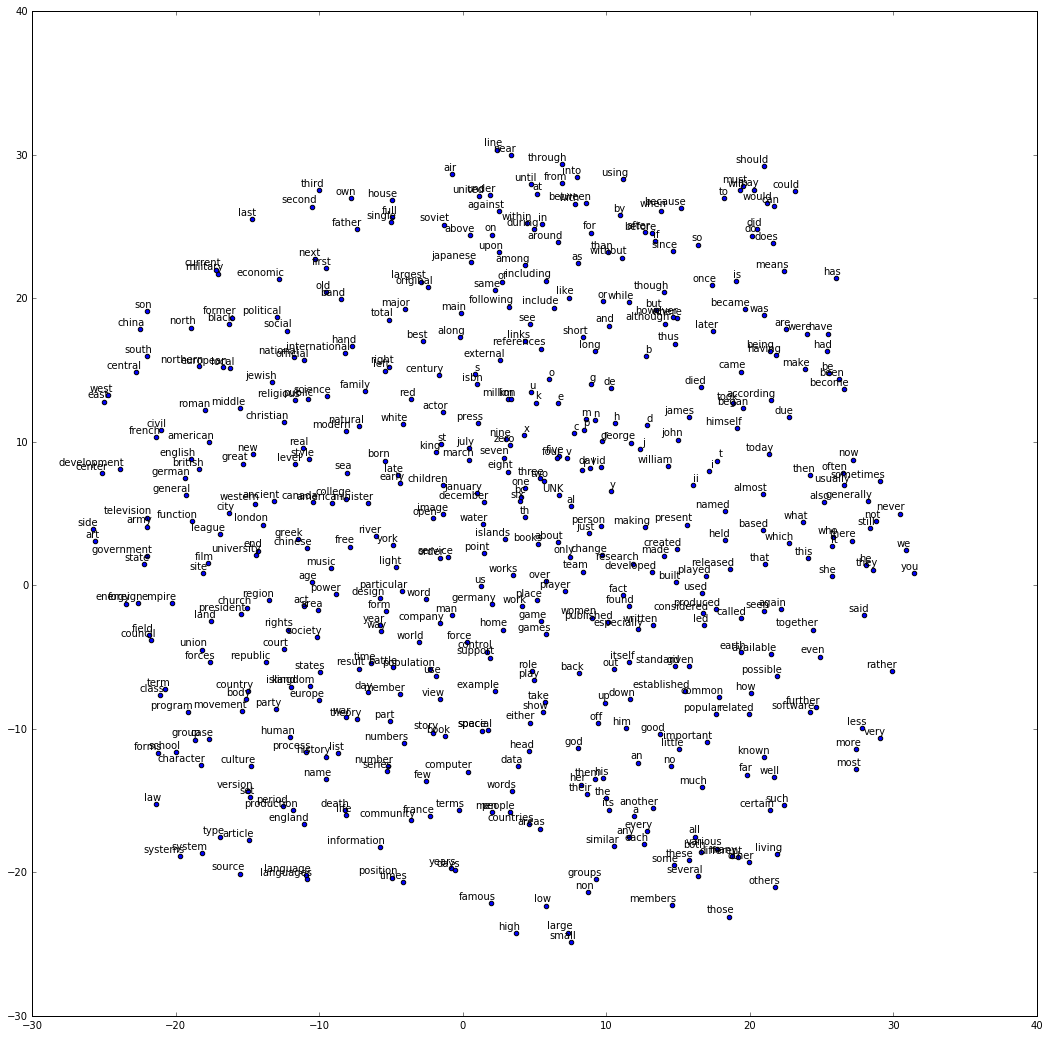

In [7]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
             xy=(x, y),
             xytext=(5, 2),
             textcoords='offset points',
             ha='right',
             va='bottom')
    plt.show()

def make_tsne(embeddings):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)
    
make_tsne(final_embeddings)